In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from joblib import parallel_backend

import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.baseline.utils import (
    get_x_and_y,
    get_class_weights,
    transform_and_scale_df,
    get_worst_params_df,
    estimate_baseline_model,
)

In [3]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [5]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scaler=False)

In [6]:
X_train, y_train = get_x_and_y(train_data, predict_draws=True)
X_valid, y_valid = get_x_and_y(valid_data, predict_draws=True)

class_weight = get_class_weights(y_train)

## Apply the Decision Tree Classifier

In [7]:
random_forest_params = {
    "max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12],
    "max_features": [None, 0.5, "sqrt"],
    "min_samples_split": [1e-5, 4e-5, 8e-5, 1e-4, 4e-4, 8e-4, 1e-3, 4e-3, 8e-3, 1e-2],
    "min_samples_leaf": [1e-6, 4e-6, 8e-6, 1e-5, 4e-5, 8e-5, 1e-4, 4e-4, 8e-4, 1e-3, 4e-3],
    "min_impurity_decrease": [1e-6, 4e-6, 8e-6, 1e-5, 4e-5, 8e-5, 1e-4, 4e-4, 8e-4, 1e-3],
    "min_weight_fraction_leaf": [0.0, 1e-6, 4e-6, 8e-6, 1e-5, 4e-5, 8e-5, 1e-4, 4e-4, 8e-4, 1e-3, 4e-3, 8e-3],
    "ccp_alpha": [0.0, 1e-6, 4e-6, 8e-6, 1e-5, 4e-5, 8e-5, 1e-4, 4e-4, 8e-4, 1e-3],
    "max_leaf_nodes": [None] + [50*i for i in range(1, 20)],
}

In [8]:
tree_model = DecisionTreeClassifier(
    class_weight=class_weight, random_state=BASELINE_RANDOM_STATE
)

random_search = RandomizedSearchCV(
    estimator=tree_model,
    param_distributions=random_forest_params,
    n_iter=10,
    cv=5,
    verbose=3,
    random_state=BASELINE_RANDOM_STATE,
    scoring="balanced_accuracy",
    return_train_score=True,
    n_jobs=-1,
)

In [ ]:
with parallel_backend("multiprocessing"):
    random_search.fit(X_train, y_train)

In [10]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.461333733736081
Best Parameters: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.001, 'min_samples_leaf': 8e-05, 'min_impurity_decrease': 8e-06, 'max_leaf_nodes': 700, 'max_features': 0.5, 'max_depth': 10, 'ccp_alpha': 4e-06}


In [11]:
get_worst_params_df(random_search.cv_results_).head(5)

mean_test_score
param_min_weight_fraction_leaf param_min_samples_split param_min_samples_leaf param_min_impurity_decrease param_max_leaf_nodes param_max_features param_max_depth param_ccp_alpha                 
0.008000                       0.00400                 0.000100               0.000001                    600                  sqrt               4               0.00001                 0.439616
                               0.00010                 0.000008               0.000400                    100                  sqrt               9               0.00001                 0.446681
0.000400                       0.00080                 0.000080               0.000008                    300                  0.5                12              0.00080                 0.448231
0.000008                       0.00800                 0.000001               0.000008                    650                  0.5                8               0.00040                 0.451941
0.000800                       0.00008                 0.000100               0.000010                    400                  sqrt               9               0.00000                 0.458017

## Apply the best model

In [12]:
args = {
    "min_weight_fraction_leaf": 0.0,
    "min_samples_split": 0.0008,
    "min_samples_leaf": 0.004,
    "min_impurity_decrease": 1e-05,
    "max_leaf_nodes": 150,
    "max_features": None,
    "max_depth": 11,
    "ccp_alpha": 4e-06,
}

best_forest_clf = DecisionTreeClassifier(
    class_weight=class_weight, random_state=BASELINE_RANDOM_STATE, **args
)

In [13]:
best_forest_clf = best_forest_clf.fit(X_train, y_train)

Log Loss on test data: 1.0353
Balanced Accuracy on test data: 46.11%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.59      0.44      0.51    378005              0.59      0.44      0.50     45215
         1-0       0.61      0.42      0.50    392248              0.61      0.43      0.50     47511
     1/2-1/2       0.05      0.55      0.09     20431              0.05      0.52      0.08      2537
    accuracy                           0.43    790684                                  0.43     95263
   macro avg       0.42      0.47      0.36    790684              0.42      0.46      0.36     95263
weighted avg       0.59      0.43      0.49    790684              0.59      0.43      0.49     95263
       


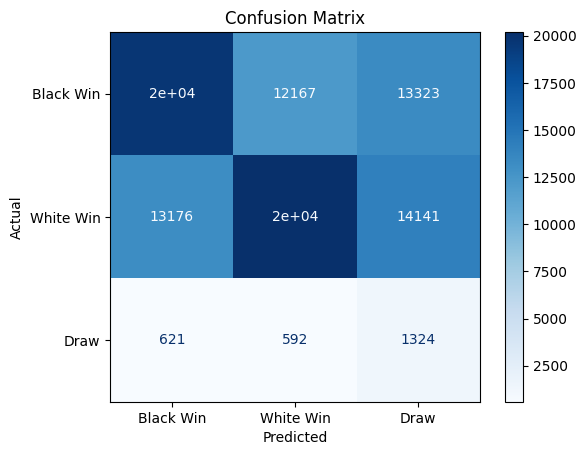

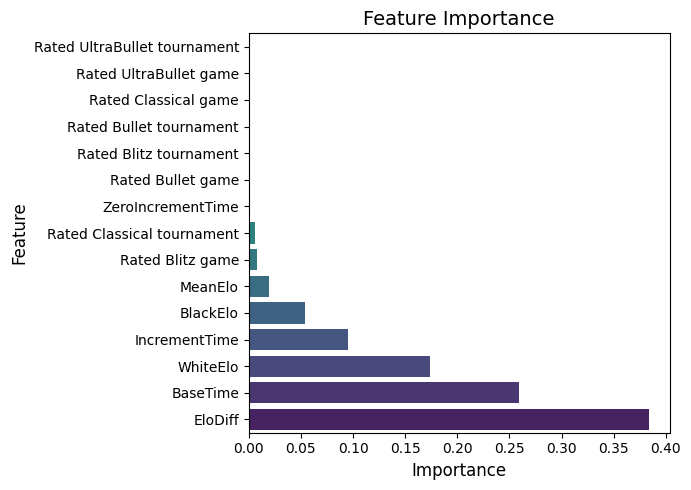

In [14]:
feature_importance = [best_forest_clf.feature_importances_]

estimate_baseline_model(
    best_forest_clf, feature_importance, X_train, y_train, X_valid, y_valid
)